In [14]:
validation_set_size = 10
BATCH_SIZE = 512
IMAGE_SIZE = 64
NUMBER_OF_PARTICLES = 0.2 #number of extra particles in image will be round(poi(NUMBER_OF_PARTICLES))
Z_RANGE = 30
NEW_MODELS=1
save_model_path = "/content/drive/My Drive/imag_n_real_feb22/"
models_path = "/content/drive/My Drive/imag_n_real_feb21/"

In [15]:
#@title Install packages
"""Import everything we need and check gpu"""
%matplotlib inline

already_installed = !pip list -v | grep deeptrack
if not already_installed:
    !pip install deeptrack==0.11.3
    !pip install mat73

import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import deeptrack as dt
import tensorflow.keras as keras
import mat73
from matplotlib import colors
from cycler import cycler
from google.colab import drive
from tensorflow.keras import layers, models

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)    
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

def save_models(models):
    drive.mount('/content/drive')
    for i, model in enumerate(models):
        model.save(save_model_path+f"model{i}")

def load_models(path, NUMBER_OF_MODELS):
    """Load models and return them in a list"""
    drive.mount('/content/drive')
    return [models.load_model(path+f"/model{i}") for i in range(NUMBER_OF_MODELS)]

Fri Mar  4 12:03:04 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    33W / 250W |   2113MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [16]:
#@title Import validation set
"""Importing the validation set"""
""" Function to import used to unpack rows of FFT-field"""
def exp_expand(data,shape):
    x = np.arange(shape[0]) - shape[0] / 2
    y = np.arange(shape[1]) - shape[1] / 2
    X, Y = np.meshgrid(x, y)
    bg=np.zeros((shape[0]*shape[1],))+0j
    X=np.reshape(np.fft.fftshift(X),(shape[0]*shape[1]))
    Y=np.reshape(np.fft.fftshift(Y),(shape[0]*shape[1]))
    RHO=X**2+Y**2
    Inds=np.argsort(RHO)
    Inds=np.sort(Inds[:data.shape[0]])

    bg[Inds[:data.shape[0]]]=data
    bg=np.reshape(bg,(shape[0],shape[1]))
  
    return bg

# Load a matfile with "downsized" ROI:s around particles found in the experimental data 
# Download mat-file from shared drive to your private one if to run in Colab!
drive.mount('/content/drive')
filePath = "/content/drive/My Drive/valset/valset_1.mat"

data = mat73.loadmat(filePath)
data = data['CompletedTraces']

shape = [64, 64]
realM = np.zeros((len(data), 64, 64, 1))
imagM = 1j * np.ones((len(data), 64, 64, 1))
savedParticles = realM + imagM

# This loop unpacks and stores all fields found in the processed video in a 3d-array
for i in range(len(data)):

    roi_data = data[i]['ROI'][0]
    roi_data = np.array(roi_data)[5, :]

    particleROI = np.fft.ifft2(exp_expand(roi_data, shape))
    particleROI = np.fft.fftshift(particleROI)
    particleROI = np.expand_dims(particleROI, axis = -1)

    savedParticles[i, :, :, :] = particleROI
    
validation_set = savedParticles[:validation_set_size] + 1

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [17]:
#@title Define optics
particle_middle = dt.MieSphere(
    position=lambda: (IMAGE_SIZE//2, IMAGE_SIZE//2),
    z=lambda: -Z_RANGE//2 + np.random.random() * Z_RANGE,
    radius=lambda: 2e-7 + 1e-7 * np.random.rand() , #1.5e-7 + 1e-7 * np.random.rand() ,
    refractive_index=lambda: 1.4 + np.random.uniform(0, 0.05),#np.random.uniform(0, 0.15) + 1.45,
    L=8,
    position_unit="pixel",
)

particle = dt.MieSphere(
    position=lambda: (IMAGE_SIZE) * np.random.rand(2),
    z=lambda: -(300+Z_RANGE//2)//2 + np.random.random()*(300+Z_RANGE//2),
    radius=lambda: 1.5e-7 + 3e-7 * np.random.rand() ,
    refractive_index=lambda: np.random.uniform(0, 0.15) + 1.45,
    L=8,
    position_unit="pixel",
)

def crop(pupil_radius):
    def inner(image):
        x = np.arange(image.shape[0]) - image.shape[0] / 2
        y = np.arange(image.shape[1]) - image.shape[1] / 2
        X, Y = np.meshgrid(x, y)
        image[X ** 2 + Y ** 2 > pupil_radius ** 2] = 0
        return image
    return inner

HC = dt.HorizontalComa(coefficient=lambda c1: c1, c1=0 + np.random.randn() * 0.05)
VC = dt.VerticalComa(coefficient=lambda c2:c2, c2=0 + np.random.randn() * 0.05)
CROP = dt.Lambda(crop, pupil_radius=180//6) #IMAGE_SIZE//6

optics = dt.Brightfield(
    NA=1.3,
    resolution=1.13e-6,
    wavelength=525e-9,
    polarization_angle=lambda: np.random.rand() * 2 * np.pi,
    magnification=10,
    output_region=(0, 0, IMAGE_SIZE, IMAGE_SIZE),
    padding=(64,) * 4,
    return_field=True,
    pupil=HC+VC + CROP,
)

real_noise = dt.Gaussian(
    mu=0, 
    sigma=lambda: 0.05 + np.random.rand() * 0.01,
)

noise = real_noise + dt.Gaussian(
    mu=0, 
    sigma=lambda: 0.05j + np.random.rand() * 0.01j,
    real_sigma=real_noise.sigma
)

gradient = dt.IlluminationGradient(
    gradient=lambda: np.random.randn(2) * 5e-5,
)

def normalization_func():
    def inner(image):
        return image - np.mean(np.real(image))
    return inner

def nonlinear_pxmapping():
    def inner(image):
        def sq(x):
            return x**1
        return sq(image)
    return inner

normalization = dt.Lambda(normalization_func)
nonlinear = dt.Lambda(nonlinear_pxmapping)

"""Plotting one random image and creating the dataset"""
def particles(particle):
    return particle ** max(0, round(np.random.poisson(lam=NUMBER_OF_PARTICLES)))
                                          
dataset = optics(particle_middle + particles(particle) + noise + gradient)# + normalization
dataset = dt.FlipLR(dt.FlipUD(dt.FlipDiagonal(dataset)))
#test_image = dataset.update().resolve()[:,:,0]

#fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(25,8))
#ax1.imshow(np.real(test_image), cmap='gray')
#ax1.set_xlabel("real part of random picture")
#ax2.imshow(np.imag(test_image), cmap='gray')
#ax2.set_xlabel("imag part of random picture")
#ax3.imshow(np.abs(test_image), cmap='gray')
#ax3.set_xlabel("abs plot of random picture")
#ax4.imshow(np.angle(test_image), cmap='gray')
#ax4.set_xlabel("phase plot of random picture")
#plt.show()

In [18]:
#@title define get_label function
"""get_label returns the z position of the middle particle, but normalized to [0,1]"""
def get_label(image):
    return np.array([image.get_property("z")])

In [19]:
from tensorflow.math import abs, angle, real, imag, subtract

class CustomLayer(keras.layers.Layer):
    "Takes a complex image as input and outputs 4 real images."
    def __init__(self):
        super().__init__()

    def build( self, input_shape):
        super().build(input_shape)

    def call(self, image):
        norm_image = subtract(image, 1)
        return tf.squeeze(tf.stack([abs(norm_image), angle(image), real(norm_image), imag(norm_image)], axis=-1), axis=-2)

"Skapar modeller!"
if True:
    if NEW_MODELS:
        models_to_train = []
        for _ in range(2):
            model = models.Sequential()
            model.add(keras.Input(shape=(IMAGE_SIZE,IMAGE_SIZE,1)))
            model.add(CustomLayer())
            model.add(layers.Conv2D(16, 7, activation='relu', strides=(3,3)))
            model.add(layers.Conv2D(32, 7, activation='relu', strides=(3,3)))
            model.add(layers.Flatten())
            model.add(layers.Dense(32, activation='relu'))
            model.add(layers.Dense(1))
            model.compile(optimizer='adam', loss='mae')
            model.totalhistory = {"val_loss":[], "loss":[]}
            model.specs="small"
            model.summary()
            models_to_train.append(model)
    else:
        models_to_train = load_models(models_path, 3)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 custom_layer_2 (CustomLayer  (None, 64, 64, 4)        0         
 )                                                               
                                                                 
 conv2d_4 (Conv2D)           (None, 20, 20, 16)        3152      
                                                                 
 conv2d_5 (Conv2D)           (None, 5, 5, 32)          25120     
                                                                 
 flatten_2 (Flatten)         (None, 800)               0         
                                                                 
 dense_4 (Dense)             (None, 32)                25632     
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                      

In [20]:
#@title
def _propagate_field(field, Tz, z, x, y, K, C, k=2 * np.pi / 0.633):
    """
    Propagate field. Field =  a Complex array of row*col dimension
    """
    Field = np.fft.fft2(field)
    Field = C * Tz * Field
    Field = np.fft.ifft2(Field)

    return Field


def _precalc(field, px, k=2 * np.pi / 0.633):
    """
    Precalculate some constants for propagating field for faster computations.
    """
    yr, xr = field.real.shape

    x = 2 * np.pi / px * np.arange(-(xr / 2 - 1 / 2), (xr / 2 + 1 / 2), 1) / xr
    y = 2 * np.pi / px * np.arange(-(yr / 2 - 1 / 2), (yr / 2 + 1 / 2), 1) / yr
    KXk, KYk = np.meshgrid(x, y)

    K = np.real(
        np.sqrt(np.array(1 - (KXk / k) ** 2 - (KYk / k) ** 2, dtype=np.complex64))
    )
    # Create a circular disk here.
    C = np.fft.fftshift(((KXk / k) ** 2 + (KYk / k) ** 2 < 1) * 1.0)

    return x, y, K, C


def _precalc_Tz(k, zv, K, C):
    return [C * np.fft.fftshift(np.exp(k * 1j * z * (K - 1))) for z in zv]


def propagation_matrix(
    z,
    shape=(IMAGE_SIZE, IMAGE_SIZE),
    padding=64,
    wavelength=525e-9,
    pixel_size=1.13e-6,
):
    field = np.zeros(np.array(shape) + padding * 2)
    k = 2 * np.pi / wavelength * 1e-6
    x, y, K, C = _precalc(field, pixel_size * 1e6, k)
    return _precalc_Tz(k, z, K, C)

def pad_fft2(image, padding):
    im = np.copy(image)
    im = np.pad(im, (padding, padding), mode="symmetric")
    return np.fft.fft2(im)

def ft_transformation(image, Tz, Tzinv, i):
    if i < 0:
        propfac=1
        for j in range(int(np.abs(i))):
            propfac*=Tzinv
        image *= propfac
    else:
        propfac=1
        for j in range(int(np.abs(i))):
            propfac*=Tz
        image *= Tz ** i
    return image

def propagate(image, z):
    """Re-propagate the images using PAS"""
    image_size = len(image[:,0,0])
    propagate_up, propagate_down = propagation_matrix(
        [.05, -.05],
        shape=(image_size, image_size),
        padding=0,
        wavelength=optics.wavelength.current_value,
        pixel_size=optics.voxel_size.current_value[0],
        )
    im = image[:,:,0]
    ft_image = pad_fft2(im, 0)
    prop_ft_image = ft_transformation(ft_image, propagate_down, propagate_up, z)
    return np.expand_dims(np.fft.ifft2(prop_ft_image),axis=-1)

In [21]:
#@title Helper functions for plotting
cc = (cycler(color=list('bgrcmyk')))

"""Helper functions to visualize progress during training."""
def save_progress(h, validation_set, validation_stack, prop_range, model):
    model.totalhistory["loss"].extend(h.history["loss"])     
    validation_deltas = accuracy_of_model(model, validation_stack, prop_range)
    std = np.std(validation_deltas[:,:,0].flatten())
    model.stats = {"sigma":np.round(std, decimals=3)}
    print(model.stats)

    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(30,8))

    ax1.plot(model.totalhistory["loss"], 'b', label="training loss")
    ax1.set_xlabel("Epoch")
    ax1.set_yscale('log')
    ax1.legend()

    ax2.hist(validation_deltas[:,:,1].flatten(), bins=list(np.linspace(-Z_RANGE/2,Z_RANGE/2,10*Z_RANGE)))
    ax2.set_xlabel("Pixlar från faktiskt värde")

    ax3.set_prop_cycle(cc)
    for i in range(validation_deltas.shape[0]):
        ax3.scatter(validation_deltas[i,:,0].flatten(), validation_deltas[i,:,1].flatten())
    ax3.set_xlabel("propagerad distans mot nätverkets fel.")

    index = np.random.randint(len(validation_set))
    ax4.imshow(np.abs(validation_set[index]-1)[:,:,0], cmap='gray')
    ax4.set_xlabel("abs av slumpmässig bild.")

    plt.show()

def plot_together(models):
    fig, ax = plt.subplots(1,1,figsize=(15,15))
    ax.set_prop_cycle(cc)
    for i, model in enumerate(models):
        ax.plot(moving_average(model.totalhistory["loss"], min(100, len(model.totalhistory["loss"])//4)), label=f"{model.specs}")
        ax.set_xlabel("Epochs")
        ax.set_ylabel("Training loss")
        ax.set_yscale("log")
        ax.legend()

    ax.grid(True)
    plt.show()

def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

simulated


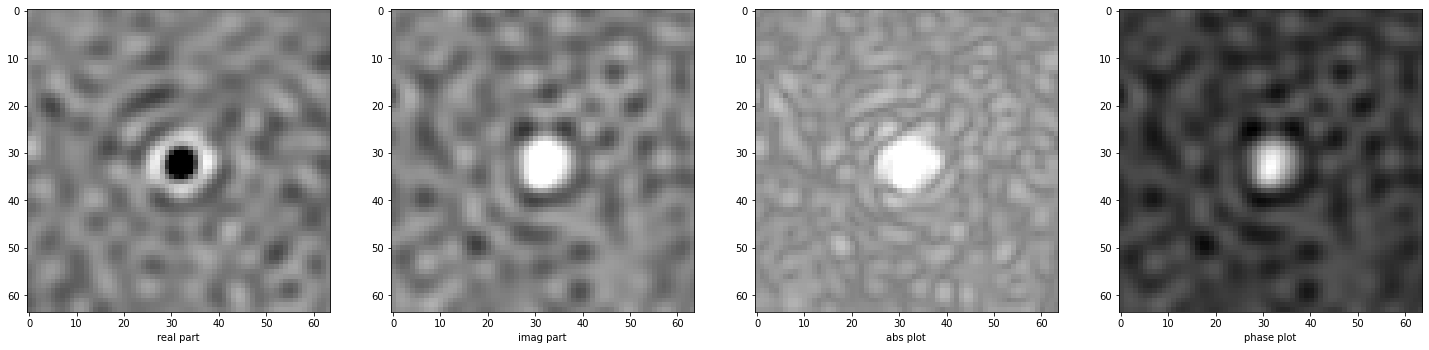

validation


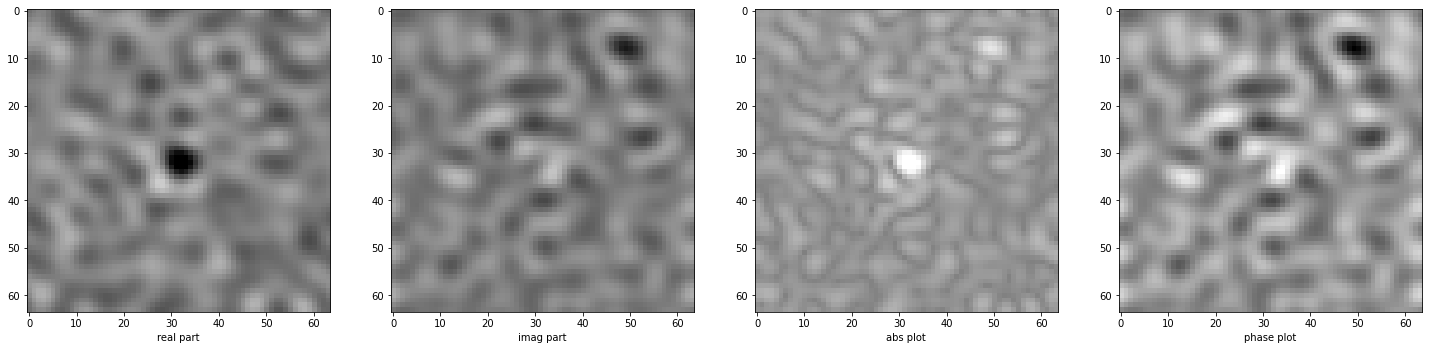

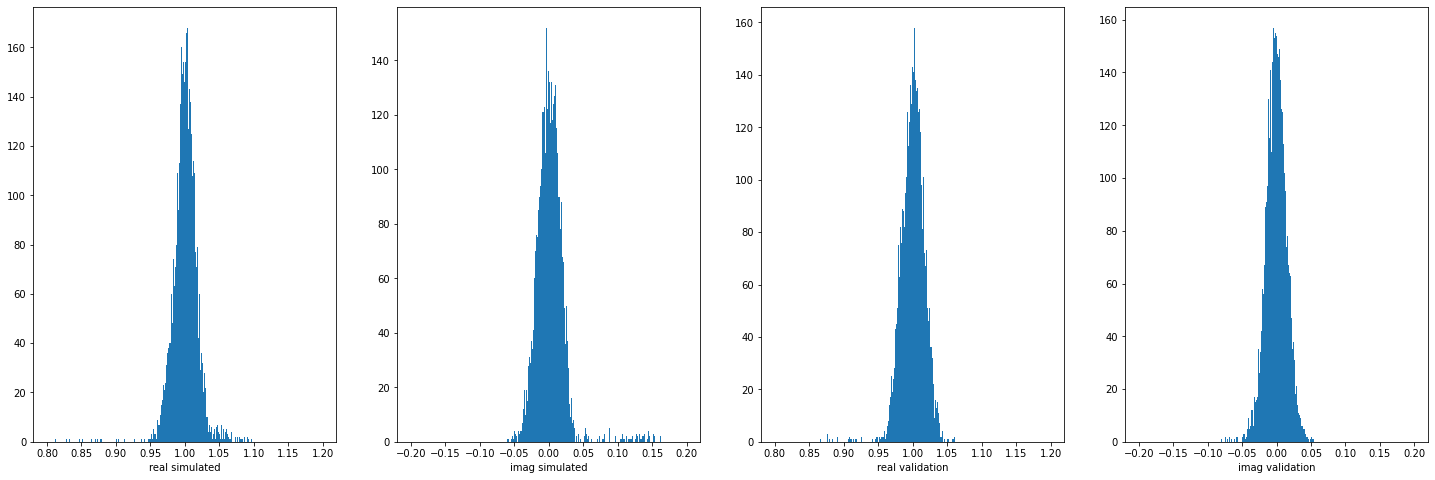

In [22]:
#@title Plot simulated and experimental images to compare
"""Plotting simulated data"""
def plot_all(image):
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(25,8))
    ax1.imshow(np.real(image-1), cmap='gray', vmin=vmin, vmax=vmax)
    ax1.set_xlabel("real part")
    ax2.imshow(np.imag(image), cmap='gray', vmin=vmin, vmax=vmax)
    ax2.set_xlabel("imag part")
    ax3.imshow(np.abs(image-1), cmap='gray', vmin=vmin, vmax=vmax)
    ax3.set_xlabel("abs plot")
    ax4.imshow(np.angle(image), cmap='gray')
    ax4.set_xlabel("phase plot")
    plt.show()

def hist_of_images(validation_image, simulated_image):
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(25,8))
    ax1.hist(np.real(simulated_image).flatten(), bins=list(np.linspace(*binz)))
    ax1.set_xlabel("real simulated")
    ax2.hist(np.imag(simulated_image).flatten(), bins=list(np.linspace(*bins)))
    ax2.set_xlabel("imag simulated")
    ax3.hist(np.real(validation_image).flatten(), bins=list(np.linspace(*binz)))
    ax3.set_xlabel("real validation")
    ax4.hist(np.imag(validation_image).flatten(), bins=list(np.linspace(*bins)))
    ax4.set_xlabel("imag validation")
    plt.show()

validation_image = np.array(validation_set)[7,:,:,0]
simulated_image = dataset.update().resolve()[:,:,0]

vmin = -0.1
vmax = 0.1
bins = (-0.2, 0.2, 300)
binz = (0.8, 1.2, 300)

print("simulated")
plot_all(simulated_image)
print("validation")
plot_all(validation_image)
hist_of_images(validation_image, simulated_image)





In [23]:
def accuracy_of_model(model, val_stack, prop_range): #propagate() tar lång tid. Behöver egentligen bara göras en gång.
    """returns a numpy tensor containing propagated distance as well as the prediction, for ever propagation distance and every image images"""
    output = []
    for i in range(val_stack.shape[0]):
        deltas = []
        images = val_stack[i,:,:,:]
        z_ref = model.predict(np.expand_dims(images[images.shape[0]//2,:,:], axis=0))
        for j, z_prop in enumerate(prop_range): #sigma will be too low because we use model.predict to set baseline.
            im = np.expand_dims(images[j,:,:,:], axis=0)
            z_pred = model.predict(im)
            z_err = float(z_ref)+z_prop-float(z_pred)
            deltas.append([z_prop, z_err])
        output.append(deltas)
    return np.array(output)


def create_validation(images, z_list):
    output = []
    for i in range(images.shape[0]):
        image = images[i,:,:,:]
        stack = []
        for z in z_list:
            stack.append(propagate(image, z))
        output.append(stack)
    return np.array(output)

prop_range = np.linspace(-10, 10, 14)
val_stack = create_validation(validation_set, prop_range)

Generating 2599 / 2560 samples before starting training
{'sigma': 6.202}


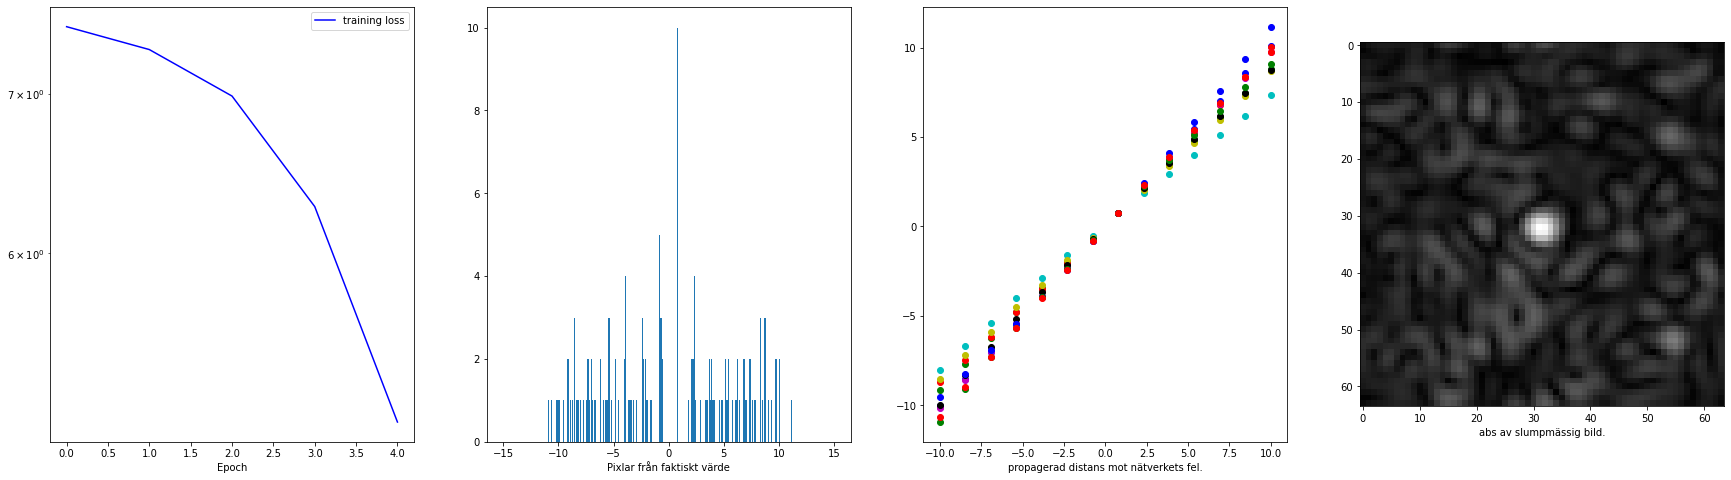

{'sigma': 6.202}


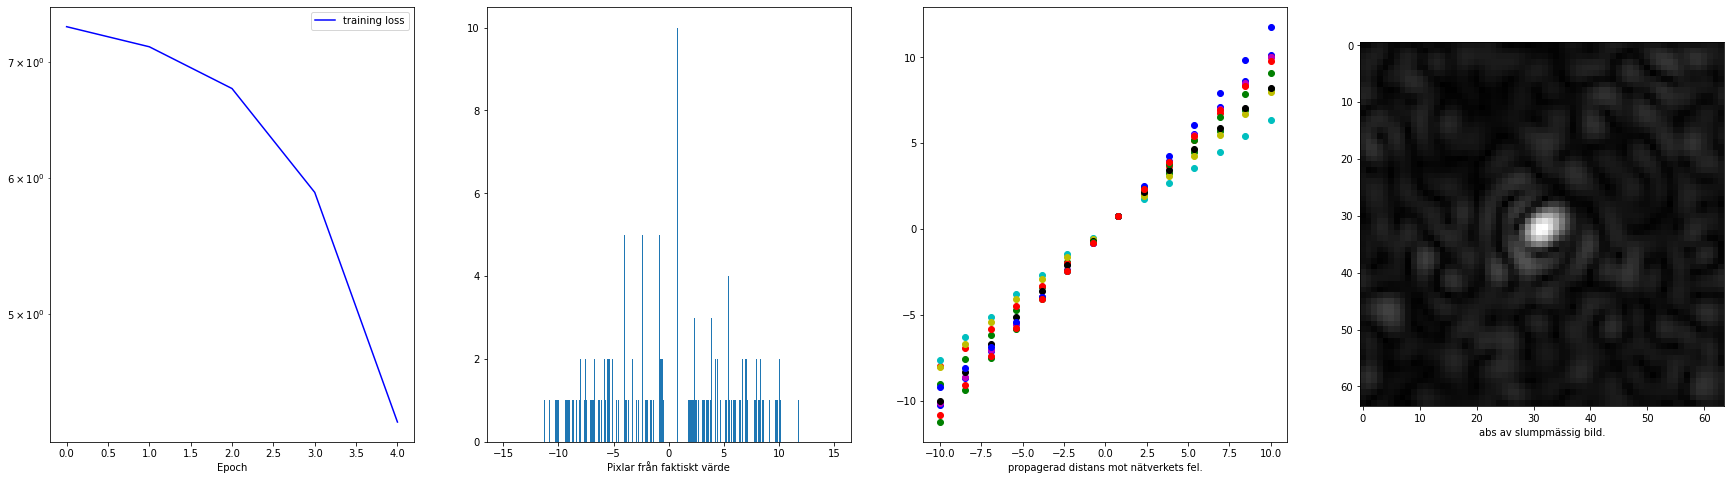

Generating 4346 / 2560 samples before starting training
{'sigma': 6.202}


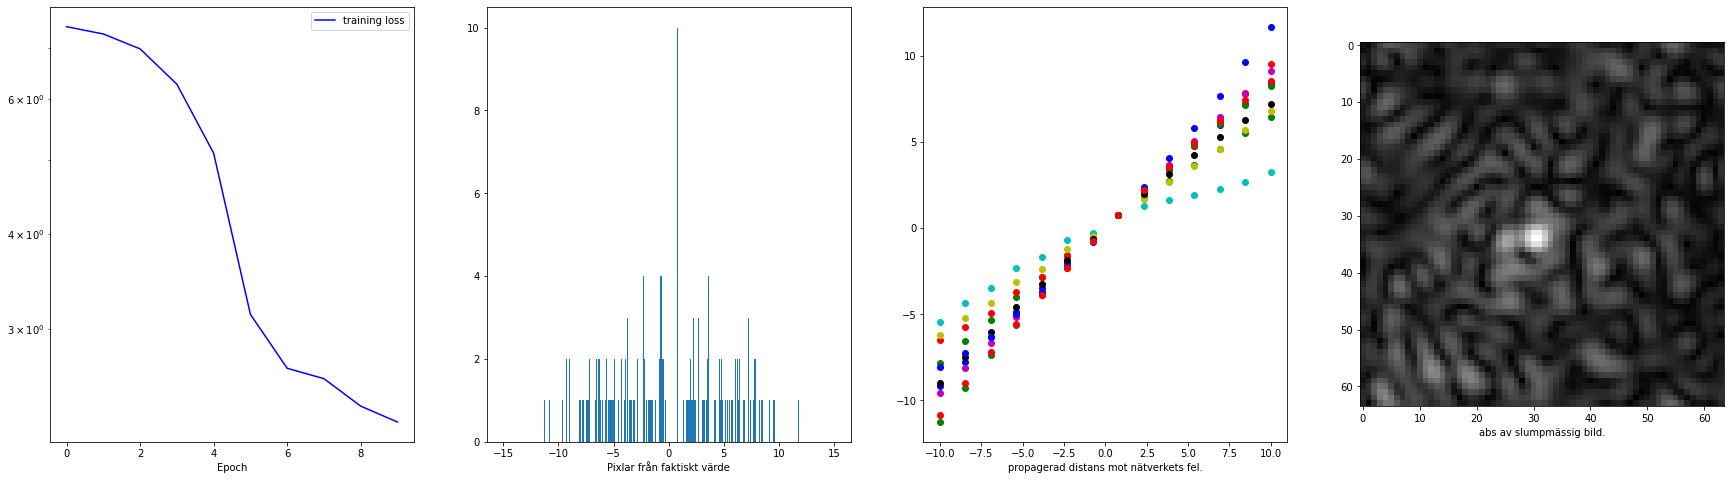

{'sigma': 6.202}


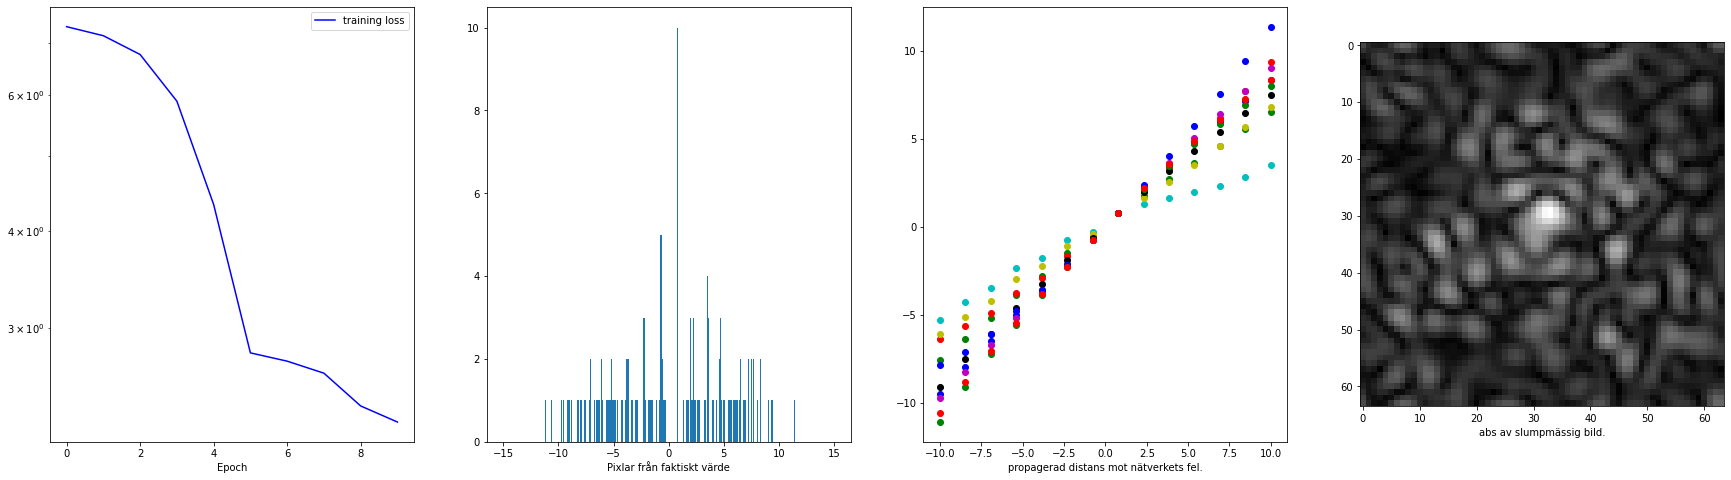

Generating 5120 / 2560 samples before starting training
{'sigma': 6.202}


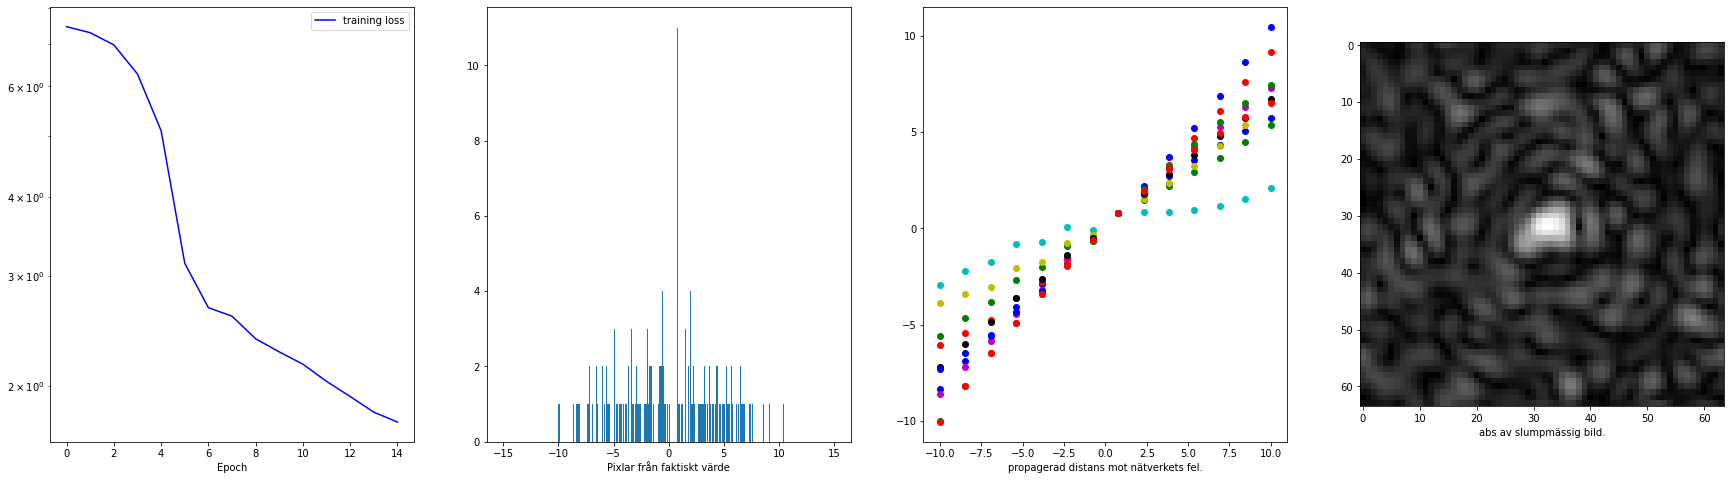

In [ ]:
"""Training all the models"""
generator = dt.generators.ContinuousGenerator(
    dataset,
    get_label,
    min_data_size=BATCH_SIZE*5,
    max_data_size=BATCH_SIZE*10,
    batch_size=BATCH_SIZE,
)

for _ in range(150):
    with generator:
        for i, model in enumerate(models_to_train):
            h = model.fit(generator, epochs=5, verbose=0,)
            save_progress(h, validation_set, val_stack, prop_range, model)

In [ ]:
"""Save models"""
save_models(models_to_train[:15])